### In this notebook I will do the following:

* I am going to show why SetFit Transformer in most of the cases improves the model's performance by plotting the data in a 2d plot.
*   Fine-tune a SentenceTransformer with a trainable classification head (SetFit) and train a classification head (Logistic Regression) using the pre-trained sentence embeddings from a SentenceTransformer model.
* SST-2 dataset from HuggingFace will be used to train the models.
*   I am going compare how good the generated pretrained and fine-tuned embeddings are by plotting the first 2 principal components using TSNE technique for dimensionality reduction.


* Import the libraries.


In [ ]:
from helper_functions import get_data, get_embedding
from sklearn.manifold import TSNE
from datasets import load_dataset
import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np


### 1) Get the pretrained sentence embeddings generated by a SentenceTransformer model without any training/fine-tuning

In [ ]:
dataset_name = 'SetFit/sst2'
model_name = 'sentence-transformers/all-mpnet-base-v2'
df = load_dataset(dataset_name)
train_df, eval_df = get_data(df=df, seed=42, nr_example_per_class=32)
train_embeddings_nofinetune = get_embedding(model_name, train_df['text'])
train_labels = np.array(train_df['label'])
eval_embeddings_nofinetune = get_embedding(model_name, eval_df['text'])
eval_labels = np.array(eval_df['label'])

### 2) Fine-tune the pretrained embeddings and train a classifier using SetFit

In [ ]:
def train_setfit(model_name, train_data, eval_data, num_iterations=20, column_mapping=None): 
    """
        Fine-Tuning of SetFit
    """
    model = SetFitModel.from_pretrained(model_name)

  # Create trainer
    trainer = SetFitTrainer(
          model=model,
          train_dataset=train_data,
          eval_dataset=eval_data,
          loss_class=CosineSimilarityLoss,
          batch_size=16,
          num_iterations=num_iterations, # Number of text pairs to generate for contrastive learning
          num_epochs=1, # Number of epochs to use for contrastive learning,
          column_mapping=column_mapping
      )

    trainer.train()
    metrics = trainer.evaluate()
    return trainer, metrics['accuracy']

In [ ]:
trainer, acc_score = train_setfit(model_name, train_df, eval_df, num_iterations=10)
train_embeddings_finetune = trainer.model.model_body.encode(train_df['text'])
eval_embeddings_finetune = trainer.model.model_body.encode(eval_df['text'])

* Let's plot the first and second principal components of the only trained and fine-tuned embeddings from training and evaluation dataset and compare them.

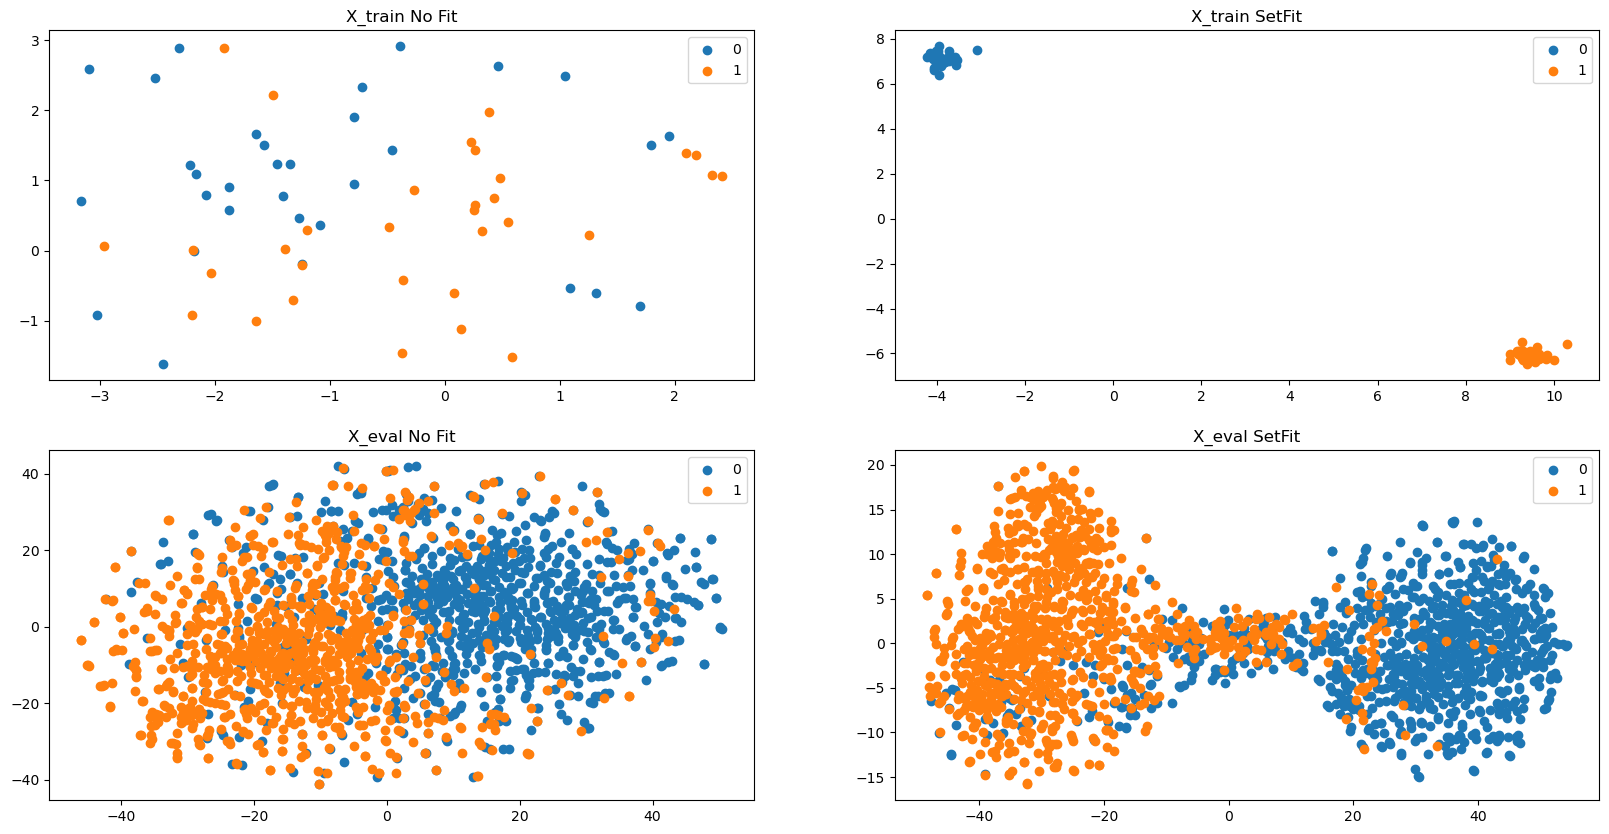

In [ ]:
plt.figure(figsize=(20,10))
train_embeddings_tsne_nofinetune = TSNE(n_components=2).fit_transform(train_embeddings_nofinetune)
plt.subplot(221)
plt.title('X_train No Fit')
for i, t in enumerate(set(train_labels)):
  idx = train_labels == t
  plt.scatter(train_embeddings_tsne_nofinetune[idx, 0], train_embeddings_tsne_nofinetune[idx, 1], label=t)  

plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval noFit
eval_embeddings_tsne_nofinetune = TSNE(n_components=2).fit_transform(eval_embeddings_nofinetune)
plt.subplot(223)
plt.title('X_eval No Fit')

for i, t in enumerate(set(np.array(eval_labels))):
    idx = eval_labels == t
    plt.scatter(eval_embeddings_tsne_nofinetune[idx, 0], eval_embeddings_tsne_nofinetune[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

#Plot X_train SetFit
train_embeddings_tsne_finetune = tsne_obj = TSNE(n_components=2).fit_transform(train_embeddings_finetune)
plt.subplot(222)
plt.title('X_train SetFit')

for i, t in enumerate(set(train_labels)):
    idx = train_labels == t
    plt.scatter(train_embeddings_tsne_finetune[idx, 0], train_embeddings_tsne_finetune[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

#Plot X_eval SetFit
eval_embeddings_tsne_finetune = TSNE(n_components=2).fit_transform(eval_embeddings_finetune)
plt.subplot(224)
plt.title('X_eval SetFit')

for i, t in enumerate(set(eval_labels)):
    idx = eval_labels == t
    plt.scatter(eval_embeddings_tsne_finetune[idx, 0], eval_embeddings_tsne_finetune[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

* We get much better representations of the embeddings after fine-tuning since the data becomes linearly separable. By using just a simple Logistic Regression model we could achieve state of the art result. 
* On the left side, without fine-tuning the data overlaps much more which makes it difficult to predict the target class. 
* Let's train a Logistic Regression using the pre-trained ST embeddings and compare the accuracy with the accuracy of SetFit.

In [ ]:
lr =  LogisticRegression()
lr.fit(train_embeddings_nofinetune, train_labels)

print(f'Accuracy No Fine-tune : {accuracy_score(eval_labels, lr.predict(eval_embeddings_nofinetune))}')
print(f'Accuracy Fine Tune : {acc_score}')

Accuracy No Fine-tune : 0.8451400329489291
Accuracy Fine Tune : 0.8797364085667215


* The general goal is to prove that just by using a few training examples with SetFit we can achieve state of the art results and compare it with the standard fine-tuning approach.